# Inference UNet 

**Objectif:** le but de ce notebook est de faire des prédictions sur les images tests. Nous allons aussi voir comment augmenter notre jeu de données avec la data augmentation. 

### Root Variables 

In [178]:
import os 

In [179]:
root = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset'
train_dir = os.path.join(root,'train/images')
gt_dir = os.path.join(root,'train/gt')
test_dir = os.path.join(root,'test/images')

In [180]:
import sys 

In [181]:
sys.path.insert(0, '/home/ign.fr/ttea/stage_segmentation_2021/Code')

### Import Libraries 

In [182]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster
import rasterio.mask
from torch.utils.data import Dataset, DataLoader
from rasterio.features import rasterize
from rasterio.windows import Window
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.merge import merge
from rasterio.plot import show

import glob

from PIL import Image
import albumentations as A
import monai
import monai.inferers
from monai.data.utils import compute_importance_map, dense_patch_slices, get_valid_patch_size
from monai.utils import BlendMode, PytorchPadMode, fall_back_tuple

In [183]:
from dataloader.dataloader import InriaDataset
from model.model import UNet
from train import train, eval, train_full

In [184]:
var = pd.read_json('variables.json')

## Inria Dataset 

### Tile Image

In [185]:
def read_image(root,filename):
    """
    read image with rasterio and return an array [C, W, H]
    
    no schema/georef returned yet.
    root : root directory 
    filename : image filename as string
    
    Returns: raster as an array 
    """
    img = rasterio.open(os.path.join(root,filename))
    img_array = img.read()
    img.close()
    return img_array

# Dataset

In [186]:
tile_size = (256,256)
train_dataset = InriaDataset(var['variables']['root'],tile_size,'train',None,False,1)
val_dataset = InriaDataset(var['variables']['root'],tile_size,'validation',None,False,1)

In [187]:
train_dataloader = DataLoader(train_dataset, 4, num_workers=6,  drop_last=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, 4, num_workers=6, drop_last=True)

In [188]:
train_dataset_hflip = InriaDataset(root, tile_size, 'train', 'HorizontalFlip', False,1)
train_dataset_vflip = InriaDataset(root, tile_size, 'train', 'VerticalFlip', False,1)
train_dataset_rot = InriaDataset(root, tile_size, 'train', 'Rotation90', False,1)

Shape pred cm (batch = 16) -> [16,256,256]

Longueur du dataloader : 4061 

Nombre d'images : 180 

Shape Tiles : (256,256)

Nb tiles par images : 361

In [189]:
hparam = {
    'lr':0.0001,
    'n_epoch':40,
    'n_epoch_test':int(5),
    'n_class':2,
    'batch_size':8,
    'n_channel':3,
    'conv_width':[16,32,64,128,256,128,64,32,16],
}

In [190]:
tile_size = (512,512)

weights = [0.5, 1.0]
class_weights = torch.FloatTensor(weights).cuda()

args = {
    'nn_loss':nn.BCEWithLogitsLoss(reduction="mean"),
    #'nn_loss':nn.CrossEntropyLoss(weight = class_weights,reduction="mean"),
    #'nn_loss':BinaryDiceLoss,
     'loss_name': 'BinaryCrossentropy',
    # 'loss_name': 'Crossentropy',
    #'loss_name':'BinaryDiceLoss',
    'threshold':0.5,
    'cuda':1,
    'class_names':['None','Batiment'],
    'save_model':True,
    'save_model_name':"unet_test_8_1.pth",
    'train_dataset':InriaDataset(var['variables']['root'],tile_size,'train',None,False,1),
    'val_dataset':InriaDataset(var['variables']['root'],tile_size,'validation',None,False,1),
}

## Loading Model

On charge le modèle qui est déjà pré-entraîné pour pouvoir l'utiliser pour l'inférence.

In [191]:
model = UNet(hparam['n_channel'], hparam['conv_width'], hparam['n_class'], cuda=args['cuda'])

save_model = '/home/ign.fr/ttea/Code_IGN/Data/model_save/unet_crossentropy.pth'
model.load_state_dict(torch.load(save_model))

<All keys matched successfully>

### Inference Method

La fonction predictor_arg va retourner l'indice de la plus grande valeur dans le tenseur. 

La fonction inference prends en entrée :
- le chemin de l'image
- la taille de la tuile 
- prédicteur
- dossier de sortie 

Retourne : Ecrit la prédiction dans une numpy array. 

Les étapes sont : 
- Ouverture du fichier avec rasterio 
- Initialisation du masque ou l'on va écrire la prédiction 
- Pour chaque tuile on va faire une prédiction puis l'écrire 
- On retourne la numpy array finale qui contient la prédiction de l'image 

In [192]:
def predictor_arg(tensor):
    return model(tensor).argmax(1) 

def inference_roi(path_image,roi_size,predictor,output_dir):
    
    # open image with rasterio 
    img =  rasterio.open(os.path.join(path_image))
    height = img.height
    width = img.width
    
    nb_col = width // roi_size[0]
    nb_row = height // roi_size[1]
    
    base=os.path.basename(path_image)
    base_without_ex = os.path.splitext(base)[0]

    profile = img.profile.copy()

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        driver = "GTiff",
        height = height,
        width = width,
        compress='lzw')

    img_transform = img.transform
    
    # Initialisation 
    mask =  np.zeros((1,width, height))
    
    shp_width = np.shape(mask)[1]
    shp_height = np.shape(mask)[2]
    
    with torch.no_grad(): 
        for col in range(0,nb_col):
            for row in range(0,nb_row):
                
                tile = img.read(window=Window(col*roi_size[0],row*roi_size[1],roi_size[0],roi_size[1]))
                tile_tensor = torch.from_numpy(tile).float()
                pred = predictor(tile_tensor.unsqueeze(dim=0))
                pred_cm = pred.cpu().detach().numpy()
                
                # Affiche Rvb & Mask 
                #show(tile)
                #show(pred_cm)
                
                mask[:,row*roi_size[1]:(row+1)*roi_size[1],col*roi_size[0]:(col+1)*roi_size[0]] = pred_cm.astype(np.uint8)
                
                # Cas unique dernière tile en diagonale
                if (col == nb_col -1) and (row == nb_row -1):
                    tile = img.read(window=Window( shp_width - roi_size[0], shp_height - roi_size[1],roi_size[0],roi_size[1]))
                    tile_tensor = torch.from_numpy(tile).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    mask[:,shp_height - roi_size[0] :,shp_width - roi_size[1]:] = pred_cm.astype(np.uint8)
                    
                
                # Dernière Row -> Recouvrement
                if row == nb_row -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window(col*roi_size[0],shp_height - roi_size[0],roi_size[0],roi_size[1]))
                    tile_tensor = torch.from_numpy(tile).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    mask[:,shp_height - roi_size[1]:,col*roi_size[0]:(col+1)*roi_size[0]] = pred_cm.astype(np.uint8)
                
                # Dernière Col -> Recouvrement 
                if col == nb_col -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window( shp_width - roi_size[0], row*roi_size[1] ,roi_size[0],roi_size[1]))
                    tile_tensor = torch.from_numpy(tile).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    mask[:,row*roi_size[1]:(row+1)*roi_size[1],shp_height - roi_size[0]:] = pred_cm.astype(np.uint8)
                    
        # Profile update (transformation)
        x,y = rasterio.transform.xy(img_transform, nb_col*roi_size[0],nb_row*roi_size[1])
        out_transform = rasterio.transform.from_origin(x,y,nb_col*roi_size[0],nb_row *roi_size[1]) 
        out_tile_name = os.path.join(output_dir,f'{base_without_ex}_{nb_col:02}_{nb_row:02}_predfinal.tif')
        profile.update(transform = out_transform)
        
        # Plot mask 
        mask = mask.astype(np.uint8)
        show(mask)
        
        with rasterio.open(out_tile_name,"w",**profile) as dst : 
            dst.write(mask)

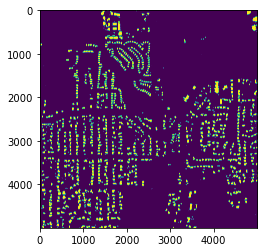

In [193]:
# inference parameter 
predictor = predictor_arg
roi_size = (256,256)

list_img = os.listdir(test_dir)
path_image = os.path.join(test_dir,list_img[2])
output_dir = r'/home/ign.fr/ttea/Code_IGN/Data/output'

inference_roi(path_image,roi_size,predictor,output_dir)

### Inference with Batch

In [194]:
def inference_roi_batch(path_image,roi_size,predictor,output_dir,batch_size):
    
    # open image with rasterio 
    img =  rasterio.open(os.path.join(path_image))
    height = img.height
    width = img.width
    
    nb_col = width // roi_size[0]
    nb_row = height // roi_size[1]
    
    base=os.path.basename(path_image)
    base_without_ex = os.path.splitext(base)[0]

    profile = img.profile.copy()

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        driver = "GTiff",
        height = height,
        width = width,
        compress='lzw')

    img_transform = img.transform
    
    # Initialisation 
    mask =  np.zeros((1,width, height))
    
    
    
    n = True
    
    shp_width = np.shape(mask)[1]
    shp_height = np.shape(mask)[2]
    
    with torch.no_grad(): 
        for col in range(0,nb_col):
            for row in range(0,nb_row):
                
                pred_list = []
                
                tile = img.read(window=Window(col*roi_size[0],row*roi_size[1],roi_size[0],roi_size[1]))
                # Dupplique la taille par rapport au nombre de batch (1,nb canaux, roi size, roi size) -> (batch_size, nb canaux, roi size, roi size)
                tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                tile_tensor = torch.from_numpy(tile).float()
                
                for i in range(batch_size):
                    #pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()          
                    pred_list.append(pred_cm)
                
                pred_avg = sum(pred_list) / 4
                    
                # Affiche Rvb & Mask 
                #show(tile)
                #show(pred_cm)
                
                mask[:,row*roi_size[1]:(row+1)*roi_size[1],col*roi_size[0]:(col+1)*roi_size[0]] = pred_avg.astype(np.uint8)
                
                # Cas unique dernière tile en diagonale
                if (col == nb_col -1) and (row == nb_row -1):
                    tile = img.read(window=Window( shp_width - roi_size[0], shp_height - roi_size[1],roi_size[0],roi_size[1]))
                    tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                    tile_tensor = torch.from_numpy(tile).float()
                    
                    for i in range(batch_size):
                        pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                        pred_cm = pred.cpu().detach().numpy()
                        pred_list.append(pred_cm)
                    
                    pred_avg = sum(pred_list) / 4
                    
                    mask[:,shp_height - roi_size[0] :,shp_width - roi_size[1]:] = pred_avg.astype(np.uint8)
                        
                # Dernière Row -> Recouvrement
                if row == nb_row -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window(col*roi_size[0],shp_height - roi_size[0],roi_size[0],roi_size[1]))
                    tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                    tile_tensor = torch.from_numpy(tile).float()
                    
                    for i in range(batch_size):
                        pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                        pred_cm = pred.cpu().detach().numpy()
                        pred_list.append(pred_cm)
                        
                    pred_avg = sum(pred_list) / 4
                    
                    mask[:,shp_height - roi_size[1]:,col*roi_size[0]:(col+1)*roi_size[0]] = pred_avg.astype(np.uint8)
                    
                # Dernière Col -> Recouvrement 
                if col == nb_col -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window( shp_width - roi_size[0], row*roi_size[1] ,roi_size[0],roi_size[1]))
                    tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                    tile_tensor = torch.from_numpy(tile).float()
                    
                    for i in range(batch_size):
                        pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                        pred_cm = pred.cpu().detach().numpy()
                        pred_list.append(pred_cm)
                        
                    pred_avg = sum(pred_list) / 4
                    
                    mask[:,row*roi_size[1]:(row+1)*roi_size[1],shp_height - roi_size[0]:] = pred_avg.astype(np.uint8)
                    
        # Profile update (transformation)
        x,y = rasterio.transform.xy(img_transform, nb_col*roi_size[0],nb_row*roi_size[1])
        out_transform = rasterio.transform.from_origin(x,y,nb_col*roi_size[0],nb_row *roi_size[1]) 
        out_tile_name = os.path.join(output_dir,f'{base_without_ex}_{nb_col:02}_{nb_row:02}_predfinal.tif')
        profile.update(transform = out_transform)
        
        # Plot mask 
        mask = mask.astype(np.uint8)
        show(mask)
        
        with rasterio.open(out_tile_name,"w",**profile) as dst : 
            dst.write(mask)

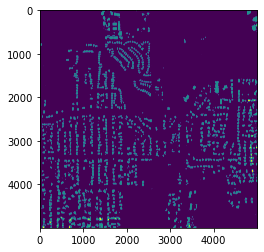

In [195]:
# inference parameter 
predictor = predictor_arg
roi_size = (256,256)
batch_size = 4

list_img = os.listdir(test_dir)
path_image = os.path.join(test_dir,list_img[2])
output_dir = r'/home/ign.fr/ttea/Code_IGN/Data/output'

inference_roi_batch(path_image,roi_size,predictor,output_dir,batch_size)

### Inference Batch with Data Augmentation 

In [299]:
def rotate(array,n):
    return np.rot90(array,k=n,axes = (1,2))
    
def rotate_inv(array_rot,n):
    # return np.rot90(array_rot,k=n+3,axes = (2,1))
    return np.rot90(array_rot, k=-n, axes = (1,2))


def inference_roi_batch_augment(path_image,roi_size,predictor,output_dir,batch_size,transform,transform_inv,transform_type):
    
    # open image with rasterio 
    img =  rasterio.open(os.path.join(path_image))
    height = img.height
    width = img.width
    
    nb_col = width // roi_size[0]
    nb_row = height // roi_size[1]
    
    base=os.path.basename(path_image)
    base_without_ex = os.path.splitext(base)[0]

    profile = img.profile.copy()

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        driver = "GTiff",
        height = height,
        width = width,
        compress='lzw')

    img_transform = img.transform
    
    # Initialisation 
    mask =  np.zeros((1,width, height))
    
    shp_width = np.shape(mask)[1]
    shp_height = np.shape(mask)[2]
    
    with torch.no_grad(): 
        for col in range(0,nb_col):
            for row in range(0,nb_row):
                
                pred_list = []
                
                tile = img.read(window=Window(col*roi_size[0],row*roi_size[1],roi_size[0],roi_size[1]))
                # Dupplique la taille par rapport au nombre de batch (1,nb canaux, roi size, roi size) -> (batch_size, nb canaux, roi size, roi size)
                tile_tensor = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                
                for i in range(batch_size):
                    if transform_type == "Radiometrie":
                        tile_tensor[i] = transform(image=tile)['image']
                    else : 
                        tile_tensor[i] = transform(tile,i+1)
                    
                # x = np.flip(tile_augment,axis=0).copy()
                tile_tensor = torch.from_numpy(tile_tensor).float()
                pred = predictor(tile_tensor)
                pred_cm = pred.cpu().detach().numpy()
                
                for i in range(batch_size):
                    if transform_type == "Rotation":                        
                        pred_cm[i] = transform_inv(np.expand_dims(pred_cm[i],axis=0),i+1)

                # pred_list.append(pred_cm)
                # pred_avg = sum(pred_list) / 4
                pred_avg = np.sum(pred_cm, axis=0) / batch_size
                    
                mask[:,row*roi_size[1]:(row+1)*roi_size[1],col*roi_size[0]:(col+1)*roi_size[0]] = pred_avg.astype(np.uint8)
                
                # Cas unique dernière tile en diagonale
                if (col == nb_col -1) and (row == nb_row -1):
                    tile = img.read(window=Window( shp_width - roi_size[0], shp_height - roi_size[1],roi_size[0],roi_size[1]))
                    tile_tensor = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)

                    for i in range(batch_size):
                        if transform_type == "Radiometrie":
                            tile_tensor[i] = transform(image=tile)['image']
                        else : 
                            tile_tensor[i] = transform(tile,i+1)

                    # x = np.flip(tile_augment,axis=0).copy()
                    tile_tensor = torch.from_numpy(tile_tensor).float()
                    pred = predictor(tile_tensor)
                    pred_cm = pred.cpu().detach().numpy()

                    for i in range(batch_size):
                        if transform_type == "Rotation":                        
                            pred_cm[i] = transform_inv(np.expand_dims(pred_cm[i],axis=0),i+1)

                    pred_avg = np.sum(pred_cm, axis=0) / batch_size
                    
                    mask[:,shp_height - roi_size[0] :,shp_width - roi_size[1]:] = pred_avg.astype(np.uint8)
                        
                # Dernière Row -> Recouvrement
                if row == nb_row -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window(col*roi_size[0],shp_height - roi_size[0],roi_size[0],roi_size[1]))
                    tile_tensor = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)

                    for i in range(batch_size):
                        if transform_type == "Radiometrie":
                            tile_tensor[i] = transform(image=tile)['image']
                        else : 
                            tile_tensor[i] = transform(tile,i+1)

                    tile_tensor = torch.from_numpy(tile_tensor).float()
                    pred = predictor(tile_tensor)
                    pred_cm = pred.cpu().detach().numpy()

                    for i in range(batch_size):
                        if transform_type == "Rotation":                        
                            pred_cm[i] = transform_inv(np.expand_dims(pred_cm[i],axis=0),i+1)

                    pred_avg = np.sum(pred_cm, axis=0) / batch_size
                    
                    mask[:,shp_height - roi_size[1]:,col*roi_size[0]:(col+1)*roi_size[0]] = pred_avg.astype(np.uint8)
                    
                # Dernière Col -> Recouvrement 
                if col == nb_col -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window( shp_width - roi_size[0], row*roi_size[1] ,roi_size[0],roi_size[1]))
                    tile_tensor = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)

                    for i in range(batch_size):
                        if transform_type == "Radiometrie":
                            tile_tensor[i] = transform(image=tile)['image']
                        else : 
                            tile_tensor[i] = transform(tile,i+1)

                    tile_tensor = torch.from_numpy(tile_tensor).float()
                    pred = predictor(tile_tensor)
                    pred_cm = pred.cpu().detach().numpy()

                    for i in range(batch_size):
                        if transform_type == "Rotation":                        
                            pred_cm[i] = transform_inv(np.expand_dims(pred_cm[i],axis=0),i+1)

                    pred_avg = np.sum(pred_cm, axis=0) / batch_size
                    
                    mask[:,row*roi_size[1]:(row+1)*roi_size[1],shp_height - roi_size[0]:] = pred_avg.astype(np.uint8)
                    
        # Profile update (transformation)
        x,y = rasterio.transform.xy(img_transform, nb_col*roi_size[0],nb_row*roi_size[1])
        out_transform = rasterio.transform.from_origin(x,y,nb_col*roi_size[0],nb_row *roi_size[1]) 
        out_tile_name = os.path.join(output_dir,f'{base_without_ex}_{nb_col:02}_{nb_row:02}_predfinal.tif')
        profile.update(transform = out_transform)
        
        # Plot mask 
        mask = mask.astype(np.uint8)
        show(mask)
        
        with rasterio.open(out_tile_name,"w",**profile) as dst : 
            dst.write(mask)

### Rotation 

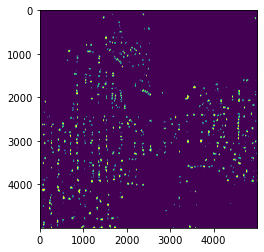

In [300]:
predictor = predictor_arg
roi_size = (256,256)
batch_size = 4

transform = rotate
transform_inv = rotate_inv
transform_type = "Rotation"

inference_roi_batch_augment(path_image,roi_size,predictor,output_dir,batch_size,transform,transform_inv,transform_type)

### Test Unitaire - Rotation 

In [301]:
def predict_tile_augment(image,transform,transform_inv):
    # open image with rasterio 
    tile =  rasterio.open(os.path.join(path_image))
    tile_array = tile.read(window=Window(256*6,3*256,512,512)) 
    
    # Affiche Tuile
    print('tile')
    show(tile_array)
    
    # Rotation
    tile_augment = transform(tile_array,1)
    
    # Affiche Tuile avec rotation
    print('tile rotate')
    show(tile_augment)
    
    x = np.flip(tile_augment,axis=0).copy()
    tile_tensor = torch.from_numpy(x).float()
    
    # Prediction
    pred = model(tile_tensor.unsqueeze(dim=0)).argmax(1)
    pred_cm= pred.cpu().detach().numpy()
    
    # Affiche Prediction de la tuile avec Rotation
    print('prediction with rotate')
    show(pred_cm)
    
    # Rotation Inverse
    pred_cm_inv = transform_inv(pred_cm,2)
    
    #pred_cm_inv = np.rot90(pred_cm,k=3,axes = (2,1))
    
    # Affiche Prediction avec Rotation Inverse
    print('prediction')
    show(pred_cm_inv)
    

In [302]:
def predict_batch_tile_augment(image,transform,transform_inv,batch_size):
    # open image with rasterio 
    tile =  rasterio.open(os.path.join(path_image))
    tile_array = tile.read(window=Window(256*6,3*256,512,512)) 
    
    # Affiche Tuile
    print('tile')
    show(tile_array)
        
    tile_tensor = np.repeat(tile_array[np.newaxis,:, :,: ], batch_size, axis=0)
    
    for i in range(batch_size): 
        tile_tensor[i] = transform(tile_array,i+1)
        print('tile rotate',i)
        show(tile_tensor[i])

    tile_tensor = torch.from_numpy(tile_tensor).float()
    
    pred = model(tile_tensor).argmax(1)
    pred_cm = pred.cpu().detach().numpy()
    
    for i in range(batch_size):
        print('pred rotate',i)
        show(pred_cm[i])
        pred_cm[i] = transform_inv(np.expand_dims(pred_cm[i],axis=0),i+1)
        print('pred',i)
        show(pred_cm[i])
    pred_avg = np.sum(pred_cm, axis=0) / batch_size

In [303]:
image = train_dataset[122]

In [304]:
batch_size = 4

tile


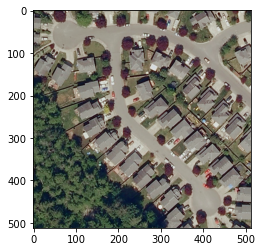

tile rotate 0


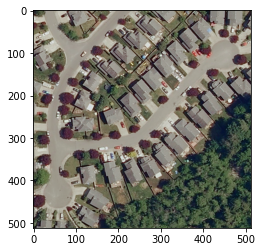

tile rotate 1


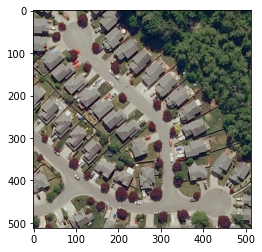

tile rotate 2


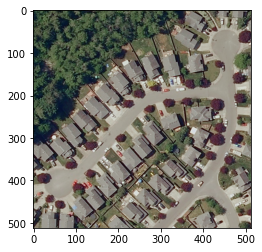

tile rotate 3


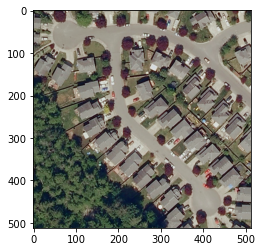

pred rotate 0


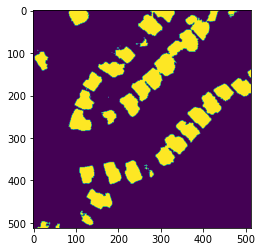

pred 0


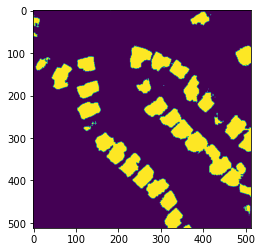

pred rotate 1


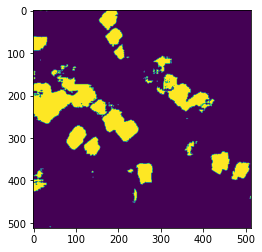

pred 1


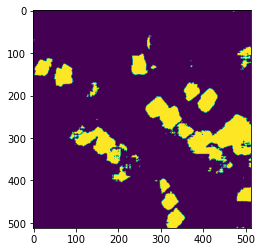

pred rotate 2


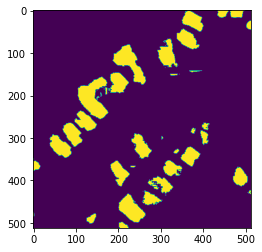

pred 2


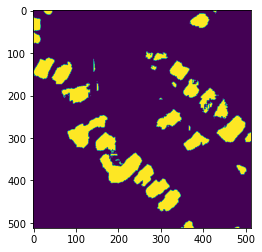

pred rotate 3


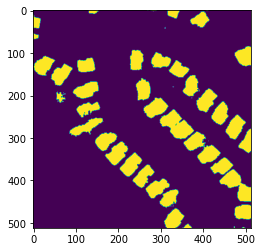

pred 3


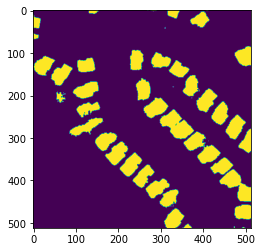

In [305]:
predict_batch_tile_augment(image,rotate,rotate_inv,batch_size)

tile


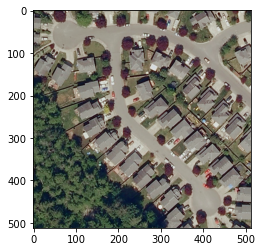

tile rotate


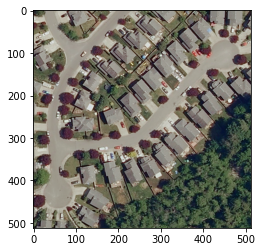

prediction with rotate


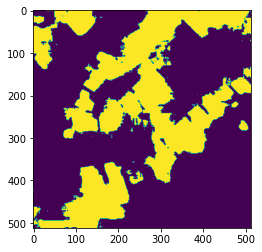

prediction


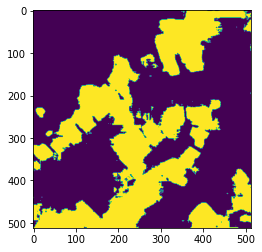

In [306]:
predict_tile_augment(image,rotate,rotate_inv)

### Radiometrie 

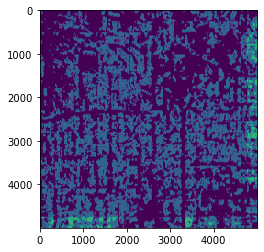

In [201]:
transform = A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0,p=1)
transform_type ="Radiometrie"

inference_roi_batch_augment(path_image,roi_size,predictor,output_dir,batch_size,transform,transform_inv,transform_type)

### Inference with Data Augmentation 

In [228]:
def predictor_arg(tensor):
    return model(tensor).argmax(1) 

def inference_roi_data_augment(path_image,roi_size,predictor,output_dir,transform,transform_inv,transform_type):
    
    # open image with rasterio 
    img =  rasterio.open(os.path.join(path_image))
    height = img.height
    width = img.width
    
    nb_col = width // roi_size[0]
    nb_row = height // roi_size[1]
    
    base=os.path.basename(path_image)
    base_without_ex = os.path.splitext(base)[0]

    profile = img.profile.copy()

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        driver = "GTiff",
        height = height,
        width = width,
        compress='lzw')

    img_transform = img.transform
    
    # Initialisation 
    mask =  np.zeros((1,width, height))
    
    shp_width = np.shape(mask)[1]
    shp_height = np.shape(mask)[2]
    
    with torch.no_grad(): 
        for col in range(0,nb_col):
            for row in range(0,nb_row):
                tile = img.read(window=Window(col*roi_size[0],row*roi_size[1],roi_size[0],roi_size[1]))
                
                if transform_type == "Radiometrie":
                    tile_augment = transform(image=tile)['image']
                else : 
                    tile_augment = transform(tile,1)
                x = np.flip(tile_augment,axis=0).copy()
                tile_tensor = torch.from_numpy(x).float()
                
                pred = predictor(tile_tensor.unsqueeze(dim=0))
                pred_cm = pred.cpu().detach().numpy()
                
                if transform_type == "Rotation":
                    pred_cm = transform_inv(pred_cm,2)
                
                mask[:,row*roi_size[1]:(row+1)*roi_size[1],col*roi_size[0]:(col+1)*roi_size[0]] = pred_cm.astype(np.uint8)
                
                # Cas unique dernière tile en diagonale
                if (col == nb_col -1) and (row == nb_row -1):
                    tile = img.read(window=Window( shp_width - roi_size[0], shp_height - roi_size[1],roi_size[0],roi_size[1]))
                    
                    if transform_type == "Radiometrie":
                        tile_augment = transform(image=tile)['image']
                    else : 
                        tile_augment = transform(tile,1)
                        x = np.flip(tile_augment,axis=0).copy()
                    
                    tile_tensor = torch.from_numpy(x).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    if transform_type == "Rotation":
                        pred_cm = transform_inv(pred_cm,2)
                    mask[:,shp_height - roi_size[0] :,shp_width - roi_size[1]:] = pred_cm.astype(np.uint8)
                    
                
                # Dernière Row -> Recouvrement
                if row == nb_row -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window(col*roi_size[0],shp_height - roi_size[0],roi_size[0],roi_size[1]))
                    
                    if transform_type == "Radiometrie":
                        tile_augment = transform(image=tile)['image']
                    else : 
                        tile_augment = transform(tile,1)

                    x = np.flip(tile_augment,axis=0).copy()
                    
                    tile_tensor = torch.from_numpy(x).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    
                    # faire la transformation inverse avant de faire la prédiction dans la cm 
                    pred_cm = pred.cpu().detach().numpy()
                    
                    if transform_type == "Rotation":
                        pred_cm = transform_inv(pred_cm,2)
                    
                    mask[:,shp_height - roi_size[1]:,col*roi_size[0]:(col+1)*roi_size[0]] = pred_cm.astype(np.uint8)
                
                # Dernière Col -> Recouvrement 
                if col == nb_col -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window( shp_width - roi_size[0], row*roi_size[1] ,roi_size[0],roi_size[1]))
                    
                    if transform_type == "Radiometrie":
                        tile_augment = transform(image=tile)['image']
                    else : 
                        tile_augment = transform(tile,1)
                    
                    x = np.flip(tile_augment,axis=0).copy()
                    
                    tile_tensor = torch.from_numpy(x).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    
                    if transform_type == "Rotation":
                        pred_cm = transform_inv(pred_cm,2)
                    mask[:,row*roi_size[1]:(row+1)*roi_size[1],shp_height - roi_size[0]:] = pred_cm.astype(np.uint8)
                    
        # Profile update (transformation)
        x,y = rasterio.transform.xy(img_transform, nb_col*roi_size[0],nb_row*roi_size[1])
        out_transform = rasterio.transform.from_origin(x,y,nb_col*roi_size[0],nb_row *roi_size[1]) 
        out_tile_name = os.path.join(output_dir,f'{base_without_ex}_{nb_col:02}_{nb_row:02}_predfinal.tif')
        profile.update(transform = out_transform)
        
        # Plot mask 
        mask = mask.astype(np.uint8)
        show(mask)
        
        with rasterio.open(out_tile_name,"w",**profile) as dst : 
            dst.write(mask)

### Rotation

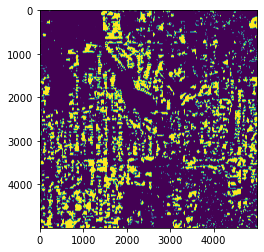

In [229]:
# inference parameter 
predictor = predictor_arg

roi_size = (256,256)

transform = rotate
transform_inv = rotate_inv
transform_type = "Rotation"

list_img = os.listdir(test_dir)
path_image = os.path.join(test_dir,list_img[2])
output_dir = r'/home/ign.fr/ttea/Code_IGN/Data/output'

inference_roi_data_augment(path_image,roi_size,predictor,output_dir,transform,transform_inv,transform_type)

### Radiométrie

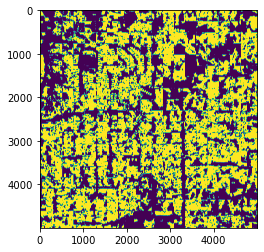

In [204]:
transform = A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0,p=1)
transform_type ="Radiometrie"

inference_roi_data_augment(path_image,roi_size,predictor,output_dir,transform,transform_inv,transform_type)

https://github.com/albumentations-team/albumentations_examples

https://medium.com/@ArjunThoughts/albumentations-package-is-a-fast-and-%EF%AC%82exible-library-for-image-augmentations-with-many-various-207422f55a24

### Test des fonctions de data augmentation 

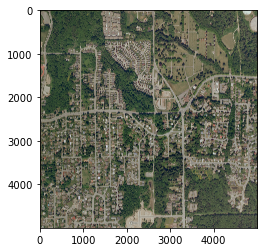

<AxesSubplot:>

In [205]:
path_img = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset/test/images'

image =  rasterio.open(os.path.join(path_img,list_img[2]))
image_array = image.read()
show(image_array)

In [206]:
np.shape(image_array)

(3, 5000, 5000)

In [207]:
# Rotation avec numpy array 
img_rot = np.rot90(image_array,k=1,axes = (1,2))

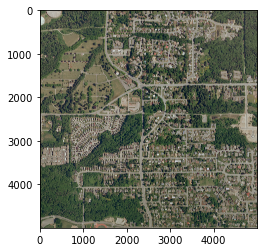

<AxesSubplot:>

In [208]:
show(img_rot)

In [209]:
# Rotation Inverse 
img_rot_inv = np.rot90(image_array,k=4,axes = (2,1))

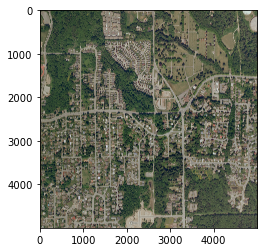

<AxesSubplot:>

In [210]:
show(img_rot_inv)

#### Albumentations Image

In [211]:
transform_rot = A.Compose([
    A.Rotate(p=1)
])

In [212]:
img_rotation = transform_rot(image=image_array)['image']

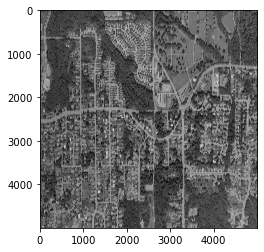

<AxesSubplot:>

In [213]:
show(img_rotation)

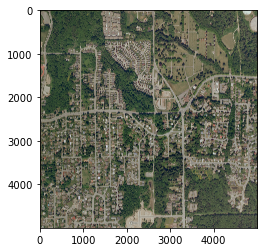

<AxesSubplot:>

In [214]:
show(image_array)

### Testing Data Augmentation with Pillow 

In [215]:
image_test =  Image.open(os.path.join(path_img,list_img[2]))

In [216]:
img_rot = image_test.rotate(90)

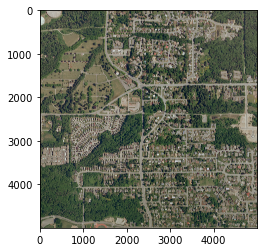

In [217]:
plt.imshow(img_rot)

In [218]:
img_rot_inv = img_rot.rotate(-90)

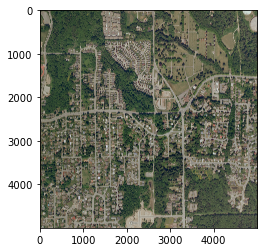

In [219]:
plt.imshow(img_rot_inv)

### Albumentations with pillow 

In [220]:
transform_color = A.Compose([
    A.GaussNoise (var_limit=(10.0, 50.0), mean=0,p=1)
])

In [221]:
transform_rot = A.Compose([
    A.Rotate(limit = 90, interpolation =1, border_mode=4, p=1)
])

In [222]:
transform_rot_inv = A.Compose([
    A.Rotate(p=1,limit = -90)
])

In [223]:
pil_rot = transform_rot(image=np.array(image_test))['image']

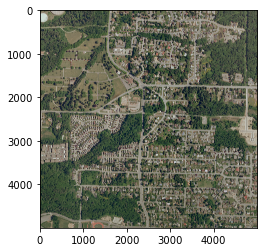

In [224]:
plt.imshow(pil_rot)

### Gaussian 

In [225]:
transform_GaussianBlur  = A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0,p=1)
transform_GaussianNoise = A.GaussNoise (var_limit=(10.0, 50.0), mean=0,p=1)

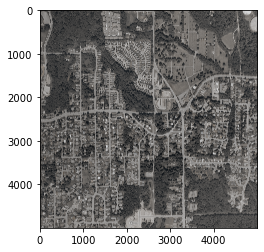

<AxesSubplot:>

In [226]:
show(transform_GaussianBlur(image=image_array)['image'])

Si l'on souhaite prédire toutes les images dans la liste des images.

In [227]:
# Predict all image in the list 

#for img in list_img:
#    path_image = os.path.join(test_dir,img)
#    inference_roi(path_image,roi_size,predictor,output_dir)